Running Model-394: 4500it [00:01, 4019.20it/s]<?, ?it/s]
Running Model-394: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Fitting node Ridge-394...


Running Model-394: 480it [00:00, 4403.74it/s]           


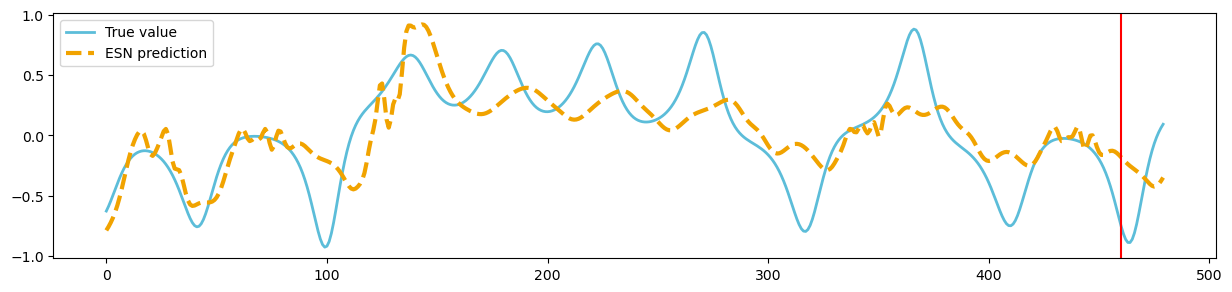

In [38]:
#Для построения архитектуры ESN использовалась библиотека reservoirPy, основанная на графовых вычислениях
import numpy as np
import math
import matplotlib.pyplot as plt
from reservoirpy.datasets import to_forecasting # разбиение на train/test
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge #узлы резервуара и считывающего слоя
from reservoirpy.observables import nrmse, rsquare
import json
from scipy.integrate import solve_ivp

length = 5000
train = 4500
forecast = 20

###ПОДГОТОВКА ДАННЫХ
#9
import warnings
from nolitsa import data

dt = 0.01
x0 = [0.62225717, -0.08232857, 30.60845379]

#000
x1 = data.lorenz(length=6500, sample=dt, x0=x0,
               sigma=16.0, beta=4.0, rho=45.92)[1]

#11
import copy
time = copy.deepcopy(x1) 
X1 = time[:,0] 
X1 = X1.reshape(6500,1) 
X1 = 2 * (X1 - X1.min()) / (X1.max() - X1.min()) - 1 
#000
    
X = X1[:5000]


def results(y_pred, y_test):
    fig = plt.figure(figsize=(15, 7))
    ax = plt.subplot(211)
    #ax.plot(np.arange(sample), y_test[len(y_test)-sample:], lw=2, label="True value", color="black")
    #ax.plot(np.arange(sample), y_pred[len(y_pred)-sample:], lw=3, label="ESN prediction", color="gray", linestyle="--")

    ax.plot(np.arange(len(y_test)), y_test, lw=2, label="True value", color="#5cbdd9")
    ax.plot(np.arange(len(y_pred)), y_pred, lw=3, label="ESN prediction", color="#f1a300", linestyle="--")
    ax.axvline(x=len(y_test)-forecast, color="red")  # Add vertical line
    ax.legend()
    plt.show()
    
###HERE0
from reservoirpy.datasets import to_forecasting

x, y = to_forecasting(X, forecast=forecast)

X_train1, y_train1 = x[:train], y[:train]
X_test1, y_test1 = x[train:], y[train:]

#Первый тестовый набор параметров 
units = 20
leak_rate = 0.3 #коэффициент утечки от 0 до 1
spectral_radius = 1.25 #от 0.1 до 1
input_scaling = 1.0
connectivity = 1.0 #от 0 до 1
input_connectivity = 0.2 #тоже %
regularization = 1e-8
seed = 1234

#узел резервуара
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)
#выходной слой(считывающее устройство)
readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
#соединяем узлы и таким образом получаем модель 
esn = reservoir >> readout

#обучение модели
esn = esn.fit(X_train1, y_train1)
#делаем предсказание
y_pred1 = esn.run(X_test1, reset=False)
results(y_pred1, X[train+forecast:])
###HERE1

In [2]:
Units = np.arange(30, 1000, 400)
Units.shape

(3,)

In [3]:
Leak_rate = np.arange(0.05, 1.0, 0.5)
Leak_rate.shape

(2,)

In [4]:
Spectral_radius = np.arange(0.1, 1.0, 0.5)
Spectral_radius.shape

(2,)

In [5]:
Input_scaling = np.arange(1.0, 5.0, 2.0)
Input_scaling.shape

(2,)

In [6]:
Connectivity = np.arange(0.01, 1.0, 0.5)
Connectivity.shape

(2,)

In [7]:
Input_connectivity = np.arange(0.01, 1.0, 0.5)
Input_connectivity.shape

(2,)

In [8]:
Regularization = np.arange(1e-8, 1.0, 0.5)
Regularization.shape

(2,)

In [9]:
Seed = np.arange(1234, 1734, 300)
Seed.shape

(2,)

In [10]:
def rmse(x_test, x_sim):
        res = 0
        for i in range(len(x_sim)):
            res = res + (x_sim[i] - x_test[i])**2
        res = math.sqrt(res/len(x_sim))
        return res

In [11]:
rmse(y_pred1[-100:], X[-100:])

C:\Users\nicks\AppData\Local\Temp\ipykernel_10316\1113348330.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res = math.sqrt(res/len(x_sim))


0.19152887822211154

In [12]:
BestRmse = 0.06389742597208328
BestHyp = np.empty((8, 1))

BestHyp[0] = 100
BestHyp[1] = 0.3
BestHyp[2] = 1.25
BestHyp[3] = 1.0
BestHyp[4] = 1.0
BestHyp[5] = 0.2
BestHyp[6] = 1e-8
BestHyp[7] = 1234

In [13]:
BestHyp[7] 

array([1234.])

In [ ]:
tmp = np.full(5000-len(y_pred1), None)
y_pred1_extended = np.concatenate([tmp.reshape(len(y_train1), 1), y_pred1])

In [14]:
for q in range(len(Units)):
    for w in range(len(Leak_rate)):
        for e in range(len(Spectral_radius)):
            for r in range(len(Input_scaling)):
                for t in range(len(Connectivity)):
                    for z in range(len(Input_connectivity)):
                        for u in range(len(Regularization)):
                            for a in range(len(Seed)):
                                #Первый тестовый набор параметров 
                                units = Units[q]
                                leak_rate = Leak_rate[w] #коэффициент утечки от 0 до 1
                                spectral_radius = Spectral_radius[e] #от 0.1 до 1
                                input_scaling = Input_scaling[r]
                                connectivity = Connectivity[t] #от 0 до 1
                                input_connectivity = Input_connectivity[z] #тоже %
                                regularization = Regularization[u]
                                seed = Seed[a]

                                #узел резервуара
                                reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                                                    lr=leak_rate, rc_connectivity=connectivity,
                                                    input_connectivity=input_connectivity, seed=seed)
                                #выходной слой(считывающее устройство)
                                readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
                                #соединяем узлы и таким образом получаем модель 
                                esn = reservoir >> readout

                                #обучение модели
                                esn = esn.fit(X_train1, y_train1)
                                #делаем предсказание
                                y_pred1 = esn.run(X_test1, reset=False)
                                #results(y_pred1, X[train+forecast:])
                                Rmse = rmse(y_pred1[-100:], X[-100:])
                                if (Rmse<BestRmse):
                                    BestRmse = Rmse
                                    BestHyp[0] = Units[q]
                                    BestHyp[1] = Leak_rate[w]
                                    BestHyp[2] = Spectral_radius[e]
                                    BestHyp[3] = Input_scaling[r]
                                    BestHyp[4] = Connectivity[t]
                                    BestHyp[5] = Input_connectivity[z]
                                    BestHyp[6] = Regularization[u]
                                    BestHyp[7] = Seed[a]


Running Model-1:   0%|          | 0/1 [00:00<?, ?it/s]

Running Model-1: 4500it [00:00, 6296.85it/s]
Running Model-1: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-1...


Running Model-1: 480it [00:00, 6439.55it/s]           
C:\Users\nicks\AppData\Local\Temp\ipykernel_10316\1113348330.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res = math.sqrt(res/len(x_sim))
Running Model-2: 4500it [00:00, 6387.12it/s]<?, ?it/s]
Running Model-2: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Fitting node Ridge-2...


Running Model-2: 480it [00:00, 7496.33it/s]           
Running Model-3: 4500it [00:00, 6938.55it/s]<?, ?it/s]
Running Model-3: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-3...


Running Model-3: 480it [00:00, 5783.54it/s]           
Running Model-4: 4500it [00:00, 4853.01it/s]<?, ?it/s]
Running Model-4: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Fitting node Ridge-4...


Running Model-4: 480it [00:00, 7036.96it/s]           
Running Model-5: 4500it [00:00, 7120.24it/s]<?, ?it/s]
Running Model-5: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-5...


Running Model-5: 480it [00:00, 8571.87it/s]           
Running Model-6: 4500it [00:00, 6658.58it/s]<?, ?it/s]
Running Model-6: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-6...


Running Model-6: 480it [00:00, 7164.85it/s]           
Running Model-7: 4500it [00:00, 6933.79it/s]<?, ?it/s]
Running Model-7: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-7...


Running Model-7: 480it [00:00, 5448.96it/s]           
Running Model-8: 4500it [00:00, 7165.53it/s]<?, ?it/s]
Running Model-8: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-8...


Running Model-8: 480it [00:00, 6856.92it/s]           
Running Model-9: 4500it [00:00, 7302.54it/s]<?, ?it/s]
Running Model-9: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Fitting node Ridge-9...


Running Model-9: 480it [00:00, 6314.29it/s]           
Running Model-10: 4500it [00:00, 7176.97it/s]<?, ?it/s]
Running Model-10: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-10...


Running Model-10: 480it [00:00, 6955.73it/s]           
Running Model-11: 4500it [00:00, 7156.38it/s]<?, ?it/s]
Running Model-11: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-11...


Running Model-11: 480it [00:00, 8273.40it/s]           
Running Model-12: 4500it [00:00, 6720.65it/s]<?, ?it/s]
Running Model-12: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-12...


Running Model-12: 480it [00:00, 8419.23it/s]           
Running Model-13: 4500it [00:00, 6122.44it/s]<?, ?it/s]
Running Model-13: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Fitting node Ridge-13...


Running Model-13: 480it [00:00, 4660.59it/s]           
Running Model-14: 4500it [00:00, 6880.52it/s]<?, ?it/s]
Running Model-14: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-14...


Running Model-14: 480it [00:00, 4571.95it/s]           
Running Model-15: 4500it [00:00, 5195.64it/s]<?, ?it/s]
Running Model-15: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Fitting node Ridge-15...


Running Model-15: 480it [00:00, 6954.65it/s]           
Running Model-16: 4500it [00:00, 4955.29it/s]<?, ?it/s]
Running Model-16: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Fitting node Ridge-16...


Running Model-16: 480it [00:00, 6233.93it/s]           
Running Model-17: 4500it [00:00, 7403.60it/s]<?, ?it/s]
Running Model-17: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Fitting node Ridge-17...


Running Model-17: 480it [00:00, 7059.56it/s]           
Running Model-18: 4500it [00:00, 6736.47it/s]<?, ?it/s]
Running Model-18: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-18...


Running Model-18: 480it [00:00, 7619.69it/s]           
Running Model-19: 4500it [00:00, 6607.95it/s]<?, ?it/s]
Running Model-19: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-19...


Running Model-19: 480it [00:00, 6486.29it/s]           
Running Model-20: 4500it [00:00, 6646.76it/s]<?, ?it/s]
Running Model-20: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-20...


Running Model-20: 480it [00:00, 7619.57it/s]           
Running Model-21: 4500it [00:00, 7758.62it/s]<?, ?it/s]
Running Model-21: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


Fitting node Ridge-21...


Running Model-21: 480it [00:00, 4948.18it/s]           
Running Model-22: 4500it [00:00, 7806.95it/s]<?, ?it/s]
Running Model-22: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


Fitting node Ridge-22...


Running Model-22: 480it [00:00, 7272.81it/s]           
Running Model-23: 4500it [00:00, 7839.75it/s]<?, ?it/s]
Running Model-23: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


Fitting node Ridge-23...


Running Model-23: 480it [00:00, 6857.38it/s]           
Running Model-24: 4500it [00:00, 6571.22it/s]<?, ?it/s]
Running Model-24: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Fitting node Ridge-24...


Running Model-24: 480it [00:00, 6956.28it/s]           
Running Model-25: 4500it [00:00, 7425.53it/s]<?, ?it/s]
Running Model-25: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Fitting node Ridge-25...


Running Model-25: 480it [00:00, 7057.78it/s]           
Running Model-26: 4500it [00:00, 6923.09it/s]<?, ?it/s]
Running Model-26: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-26...


Running Model-26: 480it [00:00, 5051.58it/s]           
Running Model-27: 4500it [00:00, 7413.38it/s]<?, ?it/s]
Running Model-27: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Fitting node Ridge-27...


Running Model-27: 480it [00:00, 6485.49it/s]           
Running Model-28: 4500it [00:00, 6756.77it/s]<?, ?it/s]
Running Model-28: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-28...


Running Model-28: 480it [00:00, 7259.12it/s]           
Running Model-29: 4500it [00:00, 6868.63it/s]<?, ?it/s]
Running Model-29: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-29...


Running Model-29: 480it [00:00, 6154.16it/s]           
Running Model-30: 4500it [00:00, 6872.37it/s]<?, ?it/s]
Running Model-30: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-30...


Running Model-30: 480it [00:00, 6153.39it/s]           
Running Model-31: 4500it [00:00, 7462.69it/s]<?, ?it/s]
Running Model-31: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-31...


Running Model-31: 480it [00:00, 7059.24it/s]           
Running Model-32: 4500it [00:00, 7614.31it/s]<?, ?it/s]
Running Model-32: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-32...


Running Model-32: 480it [00:00, 6315.40it/s]           
Running Model-33: 4500it [00:00, 7555.71it/s]<?, ?it/s]
Running Model-33: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Fitting node Ridge-33...


Running Model-33: 480it [00:00, 7272.31it/s]           
Running Model-34: 4500it [00:00, 6383.04it/s]<?, ?it/s]
Running Model-34: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Fitting node Ridge-34...


Running Model-34: 480it [00:00, 8277.24it/s]           
Running Model-35: 4500it [00:00, 7262.32it/s]<?, ?it/s]
Running Model-35: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Fitting node Ridge-35...


Running Model-35: 480it [00:00, 6858.01it/s]           
Running Model-36: 4500it [00:00, 6056.50it/s]<?, ?it/s]
Running Model-36: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Fitting node Ridge-36...


Running Model-36: 480it [00:00, 6348.77it/s]           
Running Model-37: 4500it [00:00, 6493.54it/s]<?, ?it/s]
Running Model-37: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Fitting node Ridge-37...


Running Model-37: 480it [00:00, 5925.81it/s]           
Running Model-38: 4500it [00:00, 5645.25it/s]<?, ?it/s]
Running Model-38: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Fitting node Ridge-38...


Running Model-38: 480it [00:00, 5853.47it/s]           
Running Model-39: 4500it [00:00, 7293.38it/s]<?, ?it/s]
Running Model-39: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Fitting node Ridge-39...


Running Model-39: 480it [00:00, 8135.72it/s]           
Running Model-40: 4500it [00:00, 6582.48it/s]<?, ?it/s]
Running Model-40: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-40...


Running Model-40: 480it [00:00, 6400.24it/s]           
Running Model-41: 4500it [00:00, 7220.71it/s]<?, ?it/s]
Running Model-41: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-41...


Running Model-41: 480it [00:00, 8423.07it/s]           
Running Model-42: 4500it [00:00, 6933.92it/s]<?, ?it/s]
Running Model-42: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-42...


Running Model-42: 480it [00:00, 6075.03it/s]           
Running Model-43: 4500it [00:00, 7512.48it/s]<?, ?it/s]
Running Model-43: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Fitting node Ridge-43...


Running Model-43: 480it [00:00, 4948.91it/s]           
Running Model-44: 4500it [00:00, 6987.40it/s]<?, ?it/s]
Running Model-44: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-44...


Running Model-44: 480it [00:00, 5815.58it/s]           
Running Model-45: 4500it [00:00, 7193.84it/s]<?, ?it/s]
Running Model-45: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Fitting node Ridge-45...


Running Model-45: 480it [00:00, 6400.12it/s]           
Running Model-46: 4500it [00:00, 5922.30it/s]<?, ?it/s]
Running Model-46: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Fitting node Ridge-46...


Running Model-46: 480it [00:00, 5105.68it/s]           
Running Model-47: 4500it [00:00, 7258.05it/s]<?, ?it/s]
Running Model-47: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fitting node Ridge-47...


Running Model-47: 480it [00:00, 6000.24it/s]           
Running Model-48: 4500it [00:00, 6528.20it/s]<?, ?it/s]
Running Model-48: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Fitting node Ridge-48...


Running Model-48: 480it [00:00, 4285.37it/s]           
Running Model-49: 4500it [00:00, 5801.21it/s]<?, ?it/s]
Running Model-49: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Fitting node Ridge-49...


Running Model-49: 480it [00:00, 5852.93it/s]           
Running Model-50: 4500it [00:00, 7653.04it/s]<?, ?it/s]
Running Model-50: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-50...


Running Model-50: 480it [00:00, 7619.40it/s]           
Running Model-51: 4500it [00:00, 6777.19it/s]<?, ?it/s]
Running Model-51: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-51...


Running Model-51: 480it [00:00, 5926.76it/s]           
Running Model-52: 4500it [00:00, 7475.10it/s]<?, ?it/s]
Running Model-52: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-52...


Running Model-52: 480it [00:00, 6400.59it/s]           
Running Model-53: 4500it [00:00, 5940.10it/s]<?, ?it/s]
Running Model-53: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Fitting node Ridge-53...


Running Model-53: 480it [00:00, 5218.12it/s]           
Running Model-54: 4500it [00:00, 6791.57it/s]<?, ?it/s]
Running Model-54: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-54...


Running Model-54: 480it [00:00, 6315.91it/s]           
Running Model-55: 4500it [00:00, 5529.85it/s]<?, ?it/s]
Running Model-55: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Fitting node Ridge-55...


Running Model-55: 480it [00:00, 6076.21it/s]           
Running Model-56: 4500it [00:00, 6916.22it/s]<?, ?it/s]
Running Model-56: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Fitting node Ridge-56...


Running Model-56: 480it [00:00, 7499.37it/s]           
Running Model-57: 4500it [00:00, 6756.58it/s]<?, ?it/s]
Running Model-57: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-57...


Running Model-57: 480it [00:00, 6075.99it/s]           
Running Model-58: 4500it [00:00, 6005.83it/s]<?, ?it/s]
Running Model-58: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-58...


Running Model-58: 480it [00:00, 6153.97it/s]           
Running Model-59: 4500it [00:00, 6595.71it/s]<?, ?it/s]
Running Model-59: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-59...


Running Model-59: 480it [00:00, 6760.35it/s]           
Running Model-60: 4500it [00:00, 6258.48it/s]<?, ?it/s]
Running Model-60: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-60...


Running Model-60: 480it [00:00, 4137.88it/s]           
Running Model-61: 4500it [00:00, 6671.61it/s]<?, ?it/s]
Running Model-61: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-61...


Running Model-61: 480it [00:00, 3933.98it/s]           
Running Model-62: 4500it [00:00, 6459.86it/s]<?, ?it/s]
Running Model-62: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Fitting node Ridge-62...


Running Model-62: 480it [00:00, 7741.07it/s]           
Running Model-63: 4500it [00:00, 7364.96it/s]<?, ?it/s]
Running Model-63: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Fitting node Ridge-63...


Running Model-63: 480it [00:00, 6665.83it/s]           
Running Model-64: 4500it [00:00, 6600.62it/s]<?, ?it/s]
Running Model-64: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-64...


Running Model-64: 480it [00:00, 5217.73it/s]           
Running Model-65: 4500it [00:00, 7009.28it/s]<?, ?it/s]
Running Model-65: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-65...


Running Model-65: 480it [00:00, 5852.99it/s]           
Running Model-66: 4500it [00:00, 6651.26it/s]<?, ?it/s]
Running Model-66: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-66...


Running Model-66: 480it [00:00, 8134.01it/s]           
Running Model-67: 4500it [00:00, 7283.28it/s]<?, ?it/s]
Running Model-67: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Fitting node Ridge-67...


Running Model-67: 480it [00:00, 6076.26it/s]           
Running Model-68: 4500it [00:00, 5997.90it/s]<?, ?it/s]
Running Model-68: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-68...


Running Model-68: 480it [00:00, 4486.21it/s]           
Running Model-69: 4500it [00:00, 6007.99it/s]<?, ?it/s]
Running Model-69: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-69...


Running Model-69: 480it [00:00, 3692.33it/s]           
Running Model-70: 4500it [00:00, 7120.21it/s]<?, ?it/s]
Running Model-70: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-70...


Running Model-70: 480it [00:00, 5714.51it/s]           
Running Model-71: 4500it [00:00, 6756.75it/s]<?, ?it/s]
Running Model-71: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-71...


Running Model-71: 480it [00:00, 5926.32it/s]           
Running Model-72: 4500it [00:00, 6756.77it/s]<?, ?it/s]
Running Model-72: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-72...


Running Model-72: 480it [00:00, 6760.55it/s]           
Running Model-73: 4500it [00:00, 6348.99it/s]<?, ?it/s]
Running Model-73: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-73...


Running Model-73: 480it [00:00, 6154.22it/s]           
Running Model-74: 4500it [00:00, 7440.49it/s]<?, ?it/s]
Running Model-74: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Fitting node Ridge-74...


Running Model-74: 480it [00:00, 6315.83it/s]           
Running Model-75: 4500it [00:00, 7389.25it/s]<?, ?it/s]
Running Model-75: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Fitting node Ridge-75...


Running Model-75: 480it [00:00, 3835.53it/s]           
Running Model-76: 4500it [00:00, 7631.11it/s]<?, ?it/s]
Running Model-76: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Fitting node Ridge-76...


Running Model-76: 480it [00:00, 6234.26it/s]           
Running Model-77: 4500it [00:00, 7546.92it/s]<?, ?it/s]
Running Model-77: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Fitting node Ridge-77...


Running Model-77: 480it [00:00, 6760.71it/s]           
Running Model-78: 4500it [00:00, 7389.07it/s]<?, ?it/s]
Running Model-78: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Fitting node Ridge-78...


Running Model-78: 480it [00:00, 4705.96it/s]           
Running Model-79: 4500it [00:00, 6909.04it/s]<?, ?it/s]
Running Model-79: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-79...


Running Model-79: 480it [00:00, 6667.13it/s]           
Running Model-80: 4500it [00:00, 7485.97it/s]<?, ?it/s]
Running Model-80: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-80...


Running Model-80: 480it [00:00, 7272.76it/s]           
Running Model-81: 4500it [00:00, 7329.09it/s]<?, ?it/s]
Running Model-81: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-81...


Running Model-81: 480it [00:00, 5926.04it/s]           
Running Model-82: 4500it [00:00, 7281.60it/s]<?, ?it/s]
Running Model-82: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Fitting node Ridge-82...


Running Model-82: 480it [00:00, 6180.06it/s]           
Running Model-83: 4500it [00:00, 6502.90it/s]<?, ?it/s]
Running Model-83: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Fitting node Ridge-83...


Running Model-83: 480it [00:00, 6793.40it/s]           
Running Model-84: 4500it [00:00, 6666.70it/s]<?, ?it/s]
Running Model-84: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-84...


Running Model-84: 480it [00:00, 4999.95it/s]           
Running Model-85: 4500it [00:00, 6598.16it/s]<?, ?it/s]
Running Model-85: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-85...


Running Model-85: 480it [00:00, 6315.53it/s]           
Running Model-86: 4500it [00:00, 7053.34it/s]<?, ?it/s]
Running Model-86: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Fitting node Ridge-86...


Running Model-86: 480it [00:00, 6076.50it/s]           
Running Model-87: 4500it [00:00, 7500.02it/s]<?, ?it/s]
Running Model-87: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fitting node Ridge-87...


Running Model-87: 480it [00:00, 4102.80it/s]           
Running Model-88: 4500it [00:00, 7401.21it/s]<?, ?it/s]
Running Model-88: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Fitting node Ridge-88...


Running Model-88: 480it [00:00, 6153.62it/s]           
Running Model-89: 4500it [00:00, 6965.95it/s]<?, ?it/s]
Running Model-89: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Fitting node Ridge-89...


Running Model-89: 480it [00:00, 6400.65it/s]           
Running Model-90: 4500it [00:00, 7261.15it/s]<?, ?it/s]
Running Model-90: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Fitting node Ridge-90...


Running Model-90: 480it [00:00, 6154.03it/s]           
Running Model-91: 4500it [00:00, 7437.94it/s]<?, ?it/s]
Running Model-91: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Fitting node Ridge-91...


Running Model-91: 480it [00:00, 7998.77it/s]           
Running Model-92: 4500it [00:00, 6484.09it/s]<?, ?it/s]
Running Model-92: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Fitting node Ridge-92...


Running Model-92: 480it [00:00, 5581.82it/s]           
Running Model-93: 4500it [00:00, 6965.99it/s]<?, ?it/s]
Running Model-93: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Fitting node Ridge-93...


Running Model-93: 480it [00:00, 5647.29it/s]           
Running Model-94: 4500it [00:00, 6338.06it/s]<?, ?it/s]
Running Model-94: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-94...


Running Model-94: 480it [00:00, 7058.05it/s]           
Running Model-95: 4500it [00:00, 6944.29it/s]<?, ?it/s]
Running Model-95: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-95...


Running Model-95: 480it [00:00, 5666.29it/s]           
Running Model-96: 4500it [00:00, 6963.76it/s]<?, ?it/s]
Running Model-96: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Fitting node Ridge-96...


Running Model-96: 480it [00:00, 5332.90it/s]           
Running Model-97: 4500it [00:00, 6650.33it/s]<?, ?it/s]
Running Model-97: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-97...


Running Model-97: 480it [00:00, 6666.51it/s]           
Running Model-98: 4500it [00:00, 6749.26it/s]<?, ?it/s]
Running Model-98: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-98...


Running Model-98: 480it [00:00, 6075.75it/s]           
Running Model-99: 4500it [00:00, 7146.54it/s]<?, ?it/s]
Running Model-99: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-99...


Running Model-99: 480it [00:00, 5454.50it/s]           
Running Model-100: 4500it [00:00, 7665.89it/s]<?, ?it/s]
Running Model-100: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Fitting node Ridge-100...


Running Model-100: 480it [00:00, 7502.39it/s]           
Running Model-101: 4500it [00:00, 7601.31it/s]<?, ?it/s]
Running Model-101: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-101...


Running Model-101: 480it [00:00, 6154.46it/s]           
Running Model-102: 4500it [00:00, 6114.19it/s]<?, ?it/s]
Running Model-102: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-102...


Running Model-102: 480it [00:00, 5646.45it/s]           
Running Model-103: 4500it [00:00, 6615.18it/s]<?, ?it/s]
Running Model-103: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-103...


Running Model-103: 480it [00:00, 6233.77it/s]           
Running Model-104: 4500it [00:00, 6880.71it/s]<?, ?it/s]
Running Model-104: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-104...


Running Model-104: 480it [00:00, 6419.55it/s]           
Running Model-105: 4500it [00:00, 6676.51it/s]<?, ?it/s]
Running Model-105: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-105...


Running Model-105: 480it [00:00, 4102.56it/s]           
Running Model-106: 4500it [00:00, 5897.68it/s]<?, ?it/s]
Running Model-106: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Fitting node Ridge-106...


Running Model-106: 480it [00:00, 5333.78it/s]           
Running Model-107: 4500it [00:00, 7075.51it/s]<?, ?it/s]
Running Model-107: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-107...


Running Model-107: 480it [00:00, 6076.72it/s]           
Running Model-108: 4500it [00:00, 6730.24it/s]<?, ?it/s]
Running Model-108: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Fitting node Ridge-108...


Running Model-108: 480it [00:00, 2747.06it/s]           
Running Model-109: 4500it [00:00, 4786.92it/s]<?, ?it/s]
Running Model-109: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Fitting node Ridge-109...


Running Model-109: 480it [00:00, 6075.09it/s]           
Running Model-110: 4500it [00:00, 7108.83it/s]<?, ?it/s]
Running Model-110: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-110...


Running Model-110: 480it [00:00, 5853.73it/s]           
Running Model-111: 4500it [00:00, 7375.98it/s]<?, ?it/s]
Running Model-111: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Fitting node Ridge-111...


Running Model-111: 480it [00:00, 7384.45it/s]           
Running Model-112: 4500it [00:00, 7317.11it/s]<?, ?it/s]
Running Model-112: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-112...


Running Model-112: 480it [00:00, 5714.28it/s]           
Running Model-113: 4500it [00:00, 6884.86it/s]<?, ?it/s]
Running Model-113: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-113...


Running Model-113: 480it [00:00, 4247.82it/s]           
Running Model-114: 4500it [00:00, 7409.79it/s]<?, ?it/s]
Running Model-114: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Fitting node Ridge-114...


Running Model-114: 480it [00:00, 5274.91it/s]           
Running Model-115: 4500it [00:00, 6597.03it/s]<?, ?it/s]
Running Model-115: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-115...


Running Model-115: 480it [00:00, 7741.84it/s]           
Running Model-116: 4500it [00:00, 6763.40it/s]<?, ?it/s]
Running Model-116: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-116...


Running Model-116: 480it [00:00, 6694.64it/s]           
Running Model-117: 4500it [00:00, 6354.83it/s]<?, ?it/s]
Running Model-117: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Fitting node Ridge-117...


Running Model-117: 480it [00:00, 5714.46it/s]           
Running Model-118: 4500it [00:00, 7024.94it/s]<?, ?it/s]
Running Model-118: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fitting node Ridge-118...


Running Model-118: 480it [00:00, 5888.40it/s]           
Running Model-119: 4500it [00:00, 7588.83it/s]<?, ?it/s]
Running Model-119: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fitting node Ridge-119...


Running Model-119: 480it [00:00, 5162.09it/s]           
Running Model-120: 4500it [00:00, 7042.09it/s]<?, ?it/s]
Running Model-120: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Fitting node Ridge-120...


Running Model-120: 480it [00:00, 4246.77it/s]           
Running Model-121: 4500it [00:00, 6461.60it/s]<?, ?it/s]
Running Model-121: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Fitting node Ridge-121...


Running Model-121: 480it [00:00, 6154.37it/s]           
Running Model-122: 4500it [00:00, 7031.27it/s]<?, ?it/s]
Running Model-122: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Fitting node Ridge-122...


Running Model-122: 480it [00:00, 4174.16it/s]           
Running Model-123: 4500it [00:00, 6269.20it/s]<?, ?it/s]
Running Model-123: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-123...


Running Model-123: 480it [00:00, 5853.25it/s]           
Running Model-124: 4500it [00:00, 6903.10it/s]<?, ?it/s]
Running Model-124: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-124...


Running Model-124: 480it [00:00, 6485.37it/s]           
Running Model-125: 4500it [00:00, 6617.60it/s]<?, ?it/s]
Running Model-125: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Fitting node Ridge-125...


Running Model-125: 480it [00:00, 6665.49it/s]           
Running Model-126: 4500it [00:00, 7017.86it/s]<?, ?it/s]
Running Model-126: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Fitting node Ridge-126...


Running Model-126: 480it [00:00, 5333.55it/s]           
Running Model-127: 4500it [00:00, 7089.07it/s]<?, ?it/s]
Running Model-127: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-127...


Running Model-127: 480it [00:00, 5516.17it/s]           
Running Model-128: 4500it [00:00, 6302.41it/s]<?, ?it/s]
Running Model-128: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-128...


Running Model-128: 480it [00:00, 4898.37it/s]           
Running Model-129: 4500it [00:00, 4838.55it/s]<?, ?it/s]
Running Model-129: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Fitting node Ridge-129...


Running Model-129: 480it [00:00, 5515.72it/s]           
Running Model-130: 4500it [00:00, 5837.97it/s]<?, ?it/s]
Running Model-130: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Fitting node Ridge-130...


Running Model-130: 480it [00:00, 5783.12it/s]           
Running Model-131: 4500it [00:00, 5778.73it/s]<?, ?it/s]
Running Model-131: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Fitting node Ridge-131...


Running Model-131: 480it [00:00, 5782.59it/s]           
Running Model-132: 4500it [00:00, 5717.76it/s]<?, ?it/s]
Running Model-132: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Fitting node Ridge-132...


Running Model-132: 480it [00:00, 4848.43it/s]           
Running Model-133: 4500it [00:00, 6024.44it/s]<?, ?it/s]
Running Model-133: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Fitting node Ridge-133...


Running Model-133: 480it [00:00, 5853.66it/s]           
Running Model-134: 4500it [00:00, 6440.07it/s]<?, ?it/s]
Running Model-134: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-134...


Running Model-134: 480it [00:00, 5925.50it/s]           
Running Model-135: 4500it [00:00, 6413.12it/s]<?, ?it/s]
Running Model-135: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-135...


Running Model-135: 480it [00:00, 5925.85it/s]           
Running Model-136: 4500it [00:00, 6705.20it/s]<?, ?it/s]
Running Model-136: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Fitting node Ridge-136...


Running Model-136: 480it [00:00, 4913.41it/s]           
Running Model-137: 4500it [00:01, 4451.85it/s]<?, ?it/s]
Running Model-137: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Fitting node Ridge-137...


Running Model-137: 480it [00:00, 4444.70it/s]           
Running Model-138: 4500it [00:01, 3508.27it/s]<?, ?it/s]
Running Model-138: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Fitting node Ridge-138...


Running Model-138: 480it [00:00, 4457.99it/s]           
Running Model-139: 4500it [00:01, 4174.82it/s]<?, ?it/s]
Running Model-139: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Fitting node Ridge-139...


Running Model-139: 480it [00:00, 3779.52it/s]           
Running Model-140: 4500it [00:01, 4160.28it/s]<?, ?it/s]
Running Model-140: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Fitting node Ridge-140...


Running Model-140: 480it [00:00, 3779.50it/s]           
Running Model-141: 4500it [00:01, 3399.24it/s]<?, ?it/s]
Running Model-141: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Fitting node Ridge-141...


Running Model-141: 480it [00:00, 3582.13it/s]           
Running Model-142: 4500it [00:01, 3965.84it/s]<?, ?it/s]
Running Model-142: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Fitting node Ridge-142...


Running Model-142: 480it [00:00, 3839.97it/s]           
Running Model-143: 4500it [00:01, 3534.93it/s]<?, ?it/s]
Running Model-143: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Fitting node Ridge-143...


Running Model-143: 480it [00:00, 4485.81it/s]           
Running Model-144: 4500it [00:01, 4191.07it/s]<?, ?it/s]
Running Model-144: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Fitting node Ridge-144...


Running Model-144: 480it [00:00, 3934.59it/s]           
Running Model-145: 4500it [00:00, 5747.07it/s]<?, ?it/s]
Running Model-145: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Fitting node Ridge-145...


Running Model-145: 480it [00:00, 5924.89it/s]           
Running Model-146: 4500it [00:00, 6709.81it/s]<?, ?it/s]
Running Model-146: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Fitting node Ridge-146...


Running Model-146: 480it [00:00, 5853.84it/s]           
Running Model-147: 4500it [00:00, 6242.19it/s]<?, ?it/s]
Running Model-147: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-147...


Running Model-147: 480it [00:00, 6234.84it/s]           
Running Model-148: 4500it [00:00, 7284.64it/s]<?, ?it/s]
Running Model-148: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Fitting node Ridge-148...


Running Model-148: 480it [00:00, 6760.21it/s]           
Running Model-149: 4500it [00:00, 6401.64it/s]<?, ?it/s]
Running Model-149: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-149...


Running Model-149: 480it [00:00, 4263.70it/s]           
Running Model-150: 4500it [00:00, 6905.16it/s]<?, ?it/s]
Running Model-150: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-150...


Running Model-150: 480it [00:00, 6759.71it/s]           
Running Model-151: 4500it [00:00, 5280.98it/s]<?, ?it/s]
Running Model-151: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Fitting node Ridge-151...


Running Model-151: 480it [00:00, 7270.94it/s]           
Running Model-152: 4500it [00:00, 5300.29it/s]<?, ?it/s]
Running Model-152: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Fitting node Ridge-152...


Running Model-152: 480it [00:00, 6857.29it/s]           
Running Model-153: 4500it [00:01, 2920.48it/s]<?, ?it/s]
Running Model-153: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


Fitting node Ridge-153...


Running Model-153: 480it [00:00, 3809.55it/s]           
Running Model-154: 4500it [00:01, 3993.80it/s]<?, ?it/s]
Running Model-154: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Fitting node Ridge-154...


Running Model-154: 480it [00:00, 3840.00it/s]           
Running Model-155: 4500it [00:01, 4069.24it/s]<?, ?it/s]
Running Model-155: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Fitting node Ridge-155...


Running Model-155: 480it [00:00, 4285.43it/s]           
Running Model-156: 4500it [00:01, 4017.78it/s]<?, ?it/s]
Running Model-156: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Fitting node Ridge-156...


Running Model-156: 480it [00:00, 4404.04it/s]           
Running Model-157: 4500it [00:01, 3853.55it/s]<?, ?it/s]
Running Model-157: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Fitting node Ridge-157...


Running Model-157: 480it [00:00, 4403.63it/s]           
Running Model-158: 4500it [00:01, 3187.78it/s]<?, ?it/s]
Running Model-158: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Fitting node Ridge-158...


Running Model-158: 480it [00:00, 4570.45it/s]           
Running Model-159: 4500it [00:01, 3720.86it/s]<?, ?it/s]
Running Model-159: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Fitting node Ridge-159...


Running Model-159: 480it [00:00, 4210.62it/s]           
Running Model-160: 4500it [00:01, 3800.66it/s]<?, ?it/s]
Running Model-160: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Fitting node Ridge-160...


Running Model-160: 480it [00:00, 4342.77it/s]           
Running Model-161: 4500it [00:00, 6849.33it/s]<?, ?it/s]
Running Model-161: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Fitting node Ridge-161...


Running Model-161: 480it [00:00, 6759.56it/s]           
Running Model-162: 4500it [00:00, 6403.53it/s]<?, ?it/s]
Running Model-162: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-162...


Running Model-162: 480it [00:00, 5783.35it/s]           
Running Model-163: 4500it [00:00, 6521.75it/s]<?, ?it/s]
Running Model-163: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-163...


Running Model-163: 480it [00:00, 5926.16it/s]           
Running Model-164: 4500it [00:00, 5867.00it/s]<?, ?it/s]
Running Model-164: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Fitting node Ridge-164...


Running Model-164: 480it [00:00, 6759.21it/s]           
Running Model-165: 4500it [00:00, 6421.85it/s]<?, ?it/s]
Running Model-165: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-165...


Running Model-165: 480it [00:00, 5853.88it/s]           
Running Model-166: 4500it [00:00, 6998.39it/s]<?, ?it/s]
Running Model-166: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-166...


Running Model-166: 480it [00:00, 5274.35it/s]           
Running Model-167: 4500it [00:00, 4979.45it/s]<?, ?it/s]
Running Model-167: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Fitting node Ridge-167...


Running Model-167: 480it [00:00, 5714.81it/s]           
Running Model-168: 4500it [00:00, 7055.24it/s]<?, ?it/s]
Running Model-168: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fitting node Ridge-168...


Running Model-168: 480it [00:00, 5783.27it/s]           
Running Model-169: 4500it [00:01, 4160.08it/s]<?, ?it/s]
Running Model-169: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Fitting node Ridge-169...


Running Model-169: 480it [00:00, 3967.17it/s]           
Running Model-170: 4500it [00:01, 3634.46it/s]<?, ?it/s]
Running Model-170: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Fitting node Ridge-170...


Running Model-170: 480it [00:00, 3966.84it/s]           
Running Model-171: 4500it [00:01, 3740.21it/s]<?, ?it/s]
Running Model-171: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Fitting node Ridge-171...


Running Model-171: 480it [00:00, 3477.79it/s]           
Running Model-172: 4500it [00:01, 3519.15it/s]<?, ?it/s]
Running Model-172: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Fitting node Ridge-172...


Running Model-172: 480it [00:00, 3999.47it/s]           
Running Model-173: 4500it [00:01, 4032.26it/s]<?, ?it/s]
Running Model-173: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Fitting node Ridge-173...


Running Model-173: 480it [00:00, 3265.43it/s]           
Running Model-174: 4500it [00:01, 3664.30it/s]<?, ?it/s]
Running Model-174: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Fitting node Ridge-174...


Running Model-174: 480it [00:00, 4247.74it/s]           
Running Model-175: 4500it [00:01, 3861.28it/s]<?, ?it/s]
Running Model-175: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Fitting node Ridge-175...


Running Model-175: 480it [00:00, 3933.84it/s]           
Running Model-176: 4500it [00:01, 3838.66it/s]<?, ?it/s]
Running Model-176: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Fitting node Ridge-176...


Running Model-176: 480it [00:00, 3809.10it/s]           
Running Model-177: 4500it [00:00, 5275.49it/s]<?, ?it/s]
Running Model-177: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Fitting node Ridge-177...


Running Model-177: 480it [00:00, 4752.71it/s]           
Running Model-178: 4500it [00:00, 6357.43it/s]<?, ?it/s]
Running Model-178: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-178...


Running Model-178: 480it [00:00, 6400.55it/s]           
Running Model-179: 4500it [00:00, 6055.21it/s]<?, ?it/s]
Running Model-179: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Fitting node Ridge-179...


Running Model-179: 480it [00:00, 7163.19it/s]           
Running Model-180: 4500it [00:00, 6601.69it/s]<?, ?it/s]
Running Model-180: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Fitting node Ridge-180...


Running Model-180: 480it [00:00, 5999.58it/s]           
Running Model-181: 4500it [00:00, 6933.68it/s]<?, ?it/s]
Running Model-181: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fitting node Ridge-181...


Running Model-181: 480it [00:00, 6760.49it/s]           
Running Model-182: 4500it [00:00, 5884.73it/s]<?, ?it/s]
Running Model-182: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Fitting node Ridge-182...


Running Model-182: 480it [00:00, 7498.76it/s]           
Running Model-183: 4500it [00:00, 6828.53it/s]<?, ?it/s]
Running Model-183: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Fitting node Ridge-183...


Running Model-183: 480it [00:00, 5647.17it/s]           
Running Model-184: 4500it [00:00, 7246.18it/s]<?, ?it/s]
Running Model-184: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Fitting node Ridge-184...


Running Model-184: 480it [00:00, 6076.35it/s]           
Running Model-185: 4500it [00:01, 3799.69it/s]<?, ?it/s]
Running Model-185: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Fitting node Ridge-185...


Running Model-185: 480it [00:00, 4363.91it/s]           
Running Model-186: 4500it [00:01, 3699.29it/s]<?, ?it/s]
Running Model-186: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Fitting node Ridge-186...


Running Model-186: 480it [00:00, 3674.19it/s]           
Running Model-187: 4500it [00:01, 3892.73it/s]<?, ?it/s]
Running Model-187: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Fitting node Ridge-187...


Running Model-187: 480it [00:00, 3529.33it/s]           
Running Model-188: 4500it [00:01, 4262.77it/s]<?, ?it/s]
Running Model-188: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Fitting node Ridge-188...


Running Model-188: 480it [00:00, 4098.05it/s]           
Running Model-189: 4500it [00:01, 3990.69it/s]<?, ?it/s]
Running Model-189: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Fitting node Ridge-189...


Running Model-189: 480it [00:00, 4209.81it/s]           
Running Model-190: 4500it [00:01, 4014.45it/s]<?, ?it/s]
Running Model-190: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Fitting node Ridge-190...


Running Model-190: 480it [00:00, 4284.91it/s]           
Running Model-191: 4500it [00:01, 3542.63it/s]<?, ?it/s]
Running Model-191: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Fitting node Ridge-191...


Running Model-191: 480it [00:00, 3853.86it/s]           
Running Model-192: 4500it [00:00, 4528.18it/s]<?, ?it/s]
Running Model-192: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Fitting node Ridge-192...


Running Model-192: 480it [00:00, 4443.32it/s]           
Running Model-193: 4500it [00:00, 6075.89it/s]<?, ?it/s]
Running Model-193: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Fitting node Ridge-193...


Running Model-193: 480it [00:00, 6987.93it/s]           
Running Model-194: 4500it [00:00, 6016.05it/s]<?, ?it/s]
Running Model-194: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Fitting node Ridge-194...


Running Model-194: 480it [00:00, 5853.67it/s]           
Running Model-195: 4500it [00:00, 6090.59it/s]<?, ?it/s]
Running Model-195: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Fitting node Ridge-195...


Running Model-195: 480it [00:00, 5713.82it/s]           
Running Model-196: 4500it [00:00, 6540.45it/s]<?, ?it/s]
Running Model-196: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-196...


Running Model-196: 480it [00:00, 6400.77it/s]           
Running Model-197: 4500it [00:00, 5156.78it/s]<?, ?it/s]
Running Model-197: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Fitting node Ridge-197...


Running Model-197: 480it [00:00, 6153.65it/s]           
Running Model-198: 4500it [00:00, 5910.93it/s]<?, ?it/s]
Running Model-198: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Fitting node Ridge-198...


Running Model-198: 480it [00:00, 7740.23it/s]           
Running Model-199: 4500it [00:00, 6344.01it/s]<?, ?it/s]
Running Model-199: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Fitting node Ridge-199...


Running Model-199: 480it [00:00, 5999.76it/s]           
Running Model-200: 4500it [00:00, 6683.39it/s]<?, ?it/s]
Running Model-200: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Fitting node Ridge-200...


Running Model-200: 480it [00:00, 7739.67it/s]           
Running Model-201: 4500it [00:01, 4227.71it/s]<?, ?it/s]
Running Model-201: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Fitting node Ridge-201...


Running Model-201: 480it [00:00, 4615.12it/s]           
Running Model-202: 4500it [00:01, 3890.34it/s]<?, ?it/s]
Running Model-202: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Fitting node Ridge-202...


Running Model-202: 480it [00:00, 4485.72it/s]           
Running Model-203: 4500it [00:01, 4026.31it/s]<?, ?it/s]
Running Model-203: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Fitting node Ridge-203...


Running Model-203: 480it [00:00, 3691.97it/s]           
Running Model-204: 4500it [00:01, 3391.84it/s]<?, ?it/s]
Running Model-204: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Fitting node Ridge-204...


Running Model-204: 480it [00:00, 4444.33it/s]           
Running Model-205: 4500it [00:01, 3845.71it/s]<?, ?it/s]
Running Model-205: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Fitting node Ridge-205...


Running Model-205: 480it [00:00, 4444.62it/s]           
Running Model-206: 4500it [00:01, 4144.64it/s]<?, ?it/s]
Running Model-206: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Fitting node Ridge-206...


Running Model-206: 480it [00:00, 3555.01it/s]           
Running Model-207: 4500it [00:01, 3235.69it/s]<?, ?it/s]
Running Model-207: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Fitting node Ridge-207...


Running Model-207: 480it [00:00, 3967.64it/s]           
Running Model-208: 4500it [00:01, 3968.73it/s]<?, ?it/s]
Running Model-208: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Fitting node Ridge-208...


Running Model-208: 480it [00:00, 4443.86it/s]           
Running Model-209: 4500it [00:00, 6489.30it/s]<?, ?it/s]
Running Model-209: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-209...


Running Model-209: 480it [00:00, 5647.74it/s]           
Running Model-210: 4500it [00:00, 6605.32it/s]<?, ?it/s]
Running Model-210: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-210...


Running Model-210: 480it [00:00, 6154.61it/s]           
Running Model-211: 4500it [00:00, 5257.08it/s]<?, ?it/s]
Running Model-211: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Fitting node Ridge-211...


Running Model-211: 480it [00:00, 7056.96it/s]           
Running Model-212: 4500it [00:00, 6367.60it/s]<?, ?it/s]
Running Model-212: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-212...


Running Model-212: 480it [00:00, 7058.77it/s]           
Running Model-213: 4500it [00:00, 6401.20it/s]<?, ?it/s]
Running Model-213: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-213...


Running Model-213: 480it [00:00, 4203.53it/s]           
Running Model-214: 4500it [00:00, 6641.75it/s]<?, ?it/s]
Running Model-214: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Fitting node Ridge-214...


Running Model-214: 480it [00:00, 7191.96it/s]           
Running Model-215: 4500it [00:00, 6676.35it/s]<?, ?it/s]
Running Model-215: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Fitting node Ridge-215...


Running Model-215: 480it [00:00, 5853.04it/s]           
Running Model-216: 4500it [00:00, 6501.22it/s]<?, ?it/s]
Running Model-216: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Fitting node Ridge-216...


Running Model-216: 480it [00:00, 6234.04it/s]           
Running Model-217: 4500it [00:01, 3887.00it/s]<?, ?it/s]
Running Model-217: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Fitting node Ridge-217...


Running Model-217: 480it [00:00, 4067.72it/s]           
Running Model-218: 4500it [00:01, 3081.93it/s]<?, ?it/s]
Running Model-218: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Fitting node Ridge-218...


Running Model-218: 480it [00:00, 3809.13it/s]           
Running Model-219: 4500it [00:01, 2692.26it/s]<?, ?it/s]
Running Model-219: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Fitting node Ridge-219...


Running Model-219: 480it [00:00, 3933.93it/s]           
Running Model-220: 4500it [00:01, 3192.07it/s]<?, ?it/s]
Running Model-220: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Fitting node Ridge-220...


Running Model-220: 480it [00:00, 3636.41it/s]           
Running Model-221: 4500it [00:01, 3884.46it/s]<?, ?it/s]
Running Model-221: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Fitting node Ridge-221...


Running Model-221: 480it [00:00, 4173.47it/s]           
Running Model-222: 4500it [00:01, 4200.76it/s]<?, ?it/s]
Running Model-222: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Fitting node Ridge-222...


Running Model-222: 480it [00:00, 3242.95it/s]           
Running Model-223: 4500it [00:01, 3725.26it/s]<?, ?it/s]
Running Model-223: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Fitting node Ridge-223...


Running Model-223: 480it [00:00, 3399.07it/s]           
Running Model-224: 4500it [00:01, 4458.60it/s]<?, ?it/s]
Running Model-224: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Fitting node Ridge-224...


Running Model-224: 480it [00:00, 4210.52it/s]           
Running Model-225: 4500it [00:00, 6458.71it/s]<?, ?it/s]
Running Model-225: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Fitting node Ridge-225...


Running Model-225: 480it [00:00, 6759.08it/s]           
Running Model-226: 4500it [00:00, 7028.97it/s]<?, ?it/s]
Running Model-226: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Fitting node Ridge-226...


Running Model-226: 480it [00:00, 4615.18it/s]           
Running Model-227: 4500it [00:00, 6650.23it/s]<?, ?it/s]
Running Model-227: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Fitting node Ridge-227...


Running Model-227: 480it [00:00, 6664.81it/s]           
Running Model-228: 4500it [00:00, 7135.35it/s]<?, ?it/s]
Running Model-228: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Fitting node Ridge-228...


Running Model-228: 480it [00:00, 6153.60it/s]           
Running Model-229: 4500it [00:00, 6714.90it/s]<?, ?it/s]
Running Model-229: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Fitting node Ridge-229...


Running Model-229: 480it [00:00, 5646.34it/s]           
Running Model-230: 4500it [00:00, 4756.86it/s]<?, ?it/s]
Running Model-230: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Fitting node Ridge-230...


Running Model-230: 480it [00:00, 5647.23it/s]           
Running Model-231: 4500it [00:00, 5359.76it/s]<?, ?it/s]
Running Model-231: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Fitting node Ridge-231...


Running Model-231: 480it [00:00, 6667.06it/s]           
Running Model-232: 4500it [00:00, 5686.58it/s]<?, ?it/s]
Running Model-232: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Fitting node Ridge-232...


Running Model-232: 480it [00:00, 5998.04it/s]           
Running Model-233: 4500it [00:01, 3971.65it/s]<?, ?it/s]
Running Model-233: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Fitting node Ridge-233...


Running Model-233: 480it [00:00, 3749.15it/s]           
Running Model-234: 4500it [00:01, 3950.00it/s]<?, ?it/s]
Running Model-234: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Fitting node Ridge-234...


Running Model-234: 480it [00:00, 3635.89it/s]           
Running Model-235: 4500it [00:01, 3588.97it/s]<?, ?it/s]
Running Model-235: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Fitting node Ridge-235...


Running Model-235: 480it [00:00, 4285.37it/s]           
Running Model-236: 4500it [00:01, 3143.22it/s]<?, ?it/s]
Running Model-236: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Fitting node Ridge-236...


Running Model-236: 480it [00:00, 4286.08it/s]           
Running Model-237: 4500it [00:01, 3489.55it/s]<?, ?it/s]
Running Model-237: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Fitting node Ridge-237...


Running Model-237: 480it [00:00, 3608.71it/s]           
Running Model-238: 4500it [00:01, 3940.38it/s]<?, ?it/s]
Running Model-238: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Fitting node Ridge-238...


Running Model-238: 480it [00:00, 3809.61it/s]           
Running Model-239: 4500it [00:01, 4319.64it/s]<?, ?it/s]
Running Model-239: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Fitting node Ridge-239...


Running Model-239: 480it [00:00, 3464.75it/s]           
Running Model-240: 4500it [00:01, 3816.69it/s]<?, ?it/s]
Running Model-240: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Fitting node Ridge-240...


Running Model-240: 480it [00:00, 4247.75it/s]           
Running Model-241: 4500it [00:00, 6293.77it/s]<?, ?it/s]
Running Model-241: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Fitting node Ridge-241...


Running Model-241: 480it [00:00, 6857.24it/s]           
Running Model-242: 4500it [00:00, 6748.72it/s]<?, ?it/s]
Running Model-242: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Fitting node Ridge-242...


Running Model-242: 480it [00:00, 4571.60it/s]           
Running Model-243: 4500it [00:00, 6449.69it/s]<?, ?it/s]
Running Model-243: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Fitting node Ridge-243...


Running Model-243: 480it [00:00, 5925.50it/s]           
Running Model-244: 4500it [00:00, 6838.88it/s]<?, ?it/s]
Running Model-244: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Fitting node Ridge-244...


Running Model-244: 480it [00:00, 7741.54it/s]           
Running Model-245: 4500it [00:00, 6158.85it/s]<?, ?it/s]
Running Model-245: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-245...


Running Model-245: 480it [00:00, 6153.60it/s]           
Running Model-246: 4500it [00:00, 6696.41it/s]<?, ?it/s]
Running Model-246: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Fitting node Ridge-246...


Running Model-246: 480it [00:00, 6955.70it/s]           
Running Model-247: 4500it [00:00, 6575.88it/s]<?, ?it/s]
Running Model-247: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Fitting node Ridge-247...


Running Model-247: 480it [00:00, 7618.79it/s]           
Running Model-248: 4500it [00:00, 6926.87it/s]<?, ?it/s]
Running Model-248: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Fitting node Ridge-248...


Running Model-248: 480it [00:00, 7162.20it/s]           
Running Model-249: 4500it [00:01, 3948.72it/s]<?, ?it/s]
Running Model-249: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Fitting node Ridge-249...


Running Model-249: 480it [00:00, 3809.76it/s]           
Running Model-250: 4500it [00:01, 3792.61it/s]<?, ?it/s]
Running Model-250: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Fitting node Ridge-250...


Running Model-250: 480it [00:00, 4485.28it/s]           
Running Model-251: 4500it [00:01, 3359.70it/s]<?, ?it/s]
Running Model-251: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Fitting node Ridge-251...


Running Model-251: 480it [00:00, 3934.30it/s]           
Running Model-252: 4500it [00:01, 3778.62it/s]<?, ?it/s]
Running Model-252: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Fitting node Ridge-252...


Running Model-252: 480it [00:00, 4067.66it/s]           
Running Model-253: 4500it [00:01, 3534.75it/s]<?, ?it/s]
Running Model-253: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Fitting node Ridge-253...


Running Model-253: 480it [00:00, 4324.34it/s]           
Running Model-254: 4500it [00:01, 4132.20it/s]<?, ?it/s]
Running Model-254: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Fitting node Ridge-254...


Running Model-254: 480it [00:00, 4210.66it/s]           
Running Model-255: 4500it [00:01, 2941.02it/s]<?, ?it/s]
Running Model-255: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Fitting node Ridge-255...


Running Model-255: 480it [00:00, 5000.47it/s]           
Running Model-256: 4500it [00:01, 3948.47it/s]<?, ?it/s]
Running Model-256: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Fitting node Ridge-256...


Running Model-256: 480it [00:00, 4527.91it/s]           
Running Model-257: 4500it [00:00, 5819.27it/s]<?, ?it/s]
Running Model-257: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Fitting node Ridge-257...


Running Model-257: 480it [00:00, 6856.87it/s]           
Running Model-258: 4500it [00:00, 6139.19it/s]<?, ?it/s]
Running Model-258: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Fitting node Ridge-258...


Running Model-258: 480it [00:00, 7272.23it/s]           
Running Model-259: 4500it [00:00, 6100.72it/s]<?, ?it/s]
Running Model-259: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Fitting node Ridge-259...


Running Model-259: 480it [00:00, 7384.74it/s]           
Running Model-260: 4500it [00:00, 5947.65it/s]<?, ?it/s]
Running Model-260: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Fitting node Ridge-260...


Running Model-260: 480it [00:00, 7094.59it/s]           
Running Model-261: 4500it [00:00, 6298.89it/s]<?, ?it/s]
Running Model-261: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Fitting node Ridge-261...


Running Model-261: 480it [00:00, 5332.29it/s]           
Running Model-262: 4500it [00:00, 6048.36it/s]<?, ?it/s]
Running Model-262: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Fitting node Ridge-262...


Running Model-262: 480it [00:00, 4591.65it/s]           
Running Model-263: 4500it [00:00, 5919.03it/s]<?, ?it/s]
Running Model-263: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Fitting node Ridge-263...


Running Model-263: 480it [00:00, 6315.43it/s]           
Running Model-264: 4500it [00:00, 5821.46it/s]<?, ?it/s]
Running Model-264: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Fitting node Ridge-264...


Running Model-264: 480it [00:00, 7164.62it/s]           
Running Model-265: 4500it [00:03, 1478.14it/s]<?, ?it/s]
Running Model-265: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


Fitting node Ridge-265...


Running Model-265: 480it [00:00, 1707.96it/s]           
Running Model-266: 4500it [00:03, 1381.59it/s]<?, ?it/s]
Running Model-266: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


Fitting node Ridge-266...


Running Model-266: 480it [00:00, 1482.32it/s]           
Running Model-267: 4500it [00:03, 1363.57it/s]<?, ?it/s]
Running Model-267: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it]


Fitting node Ridge-267...


Running Model-267: 480it [00:00, 1640.43it/s]           
Running Model-268: 4500it [00:03, 1413.14it/s]<?, ?it/s]
Running Model-268: 100%|██████████| 1/1 [00:03<00:00,  3.34s/it]


Fitting node Ridge-268...


Running Model-268: 480it [00:00, 1523.79it/s]           
Running Model-269: 4500it [00:03, 1457.74it/s]<?, ?it/s]
Running Model-269: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


Fitting node Ridge-269...


Running Model-269: 480it [00:00, 1355.90it/s]           
Running Model-270: 4500it [00:02, 1561.17it/s]<?, ?it/s]
Running Model-270: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


Fitting node Ridge-270...


Running Model-270: 480it [00:00, 1600.06it/s]           
Running Model-271: 4500it [00:02, 1558.21it/s]<?, ?it/s]
Running Model-271: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


Fitting node Ridge-271...


Running Model-271: 480it [00:00, 1784.88it/s]           
Running Model-272: 4500it [00:03, 1432.36it/s]<?, ?it/s]
Running Model-272: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it]


Fitting node Ridge-272...


Running Model-272: 480it [00:00, 1620.50it/s]           
Running Model-273: 4500it [00:00, 6451.01it/s]<?, ?it/s]
Running Model-273: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-273...


Running Model-273: 480it [00:00, 6488.27it/s]           
Running Model-274: 4500it [00:00, 6345.29it/s]<?, ?it/s]
Running Model-274: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Fitting node Ridge-274...


Running Model-274: 480it [00:00, 6956.11it/s]           
Running Model-275: 4500it [00:00, 6413.35it/s]<?, ?it/s]
Running Model-275: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Fitting node Ridge-275...


Running Model-275: 480it [00:00, 5781.91it/s]           
Running Model-276: 4500it [00:00, 6751.03it/s]<?, ?it/s]
Running Model-276: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Fitting node Ridge-276...


Running Model-276: 480it [00:00, 5853.18it/s]           
Running Model-277: 4500it [00:00, 6151.08it/s]<?, ?it/s]
Running Model-277: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Fitting node Ridge-277...


Running Model-277: 480it [00:00, 7382.25it/s]           
Running Model-278: 4500it [00:00, 6329.67it/s]<?, ?it/s]
Running Model-278: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Fitting node Ridge-278...


Running Model-278: 480it [00:00, 5454.70it/s]           
Running Model-279: 4500it [00:00, 5549.23it/s]<?, ?it/s]
Running Model-279: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Fitting node Ridge-279...


Running Model-279: 480it [00:00, 6666.51it/s]           
Running Model-280: 4500it [00:00, 5684.73it/s]<?, ?it/s]
Running Model-280: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Fitting node Ridge-280...


Running Model-280: 480it [00:00, 4321.97it/s]           
Running Model-281: 4500it [00:03, 1408.95it/s]<?, ?it/s]
Running Model-281: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


Fitting node Ridge-281...


Running Model-281: 480it [00:00, 1455.12it/s]           
Running Model-282: 4500it [00:03, 1426.38it/s]<?, ?it/s]
Running Model-282: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]


Fitting node Ridge-282...


Running Model-282: 480it [00:00, 1482.85it/s]           
Running Model-283: 4500it [00:03, 1451.30it/s]<?, ?it/s]
Running Model-283: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]


Fitting node Ridge-283...


Running Model-283: 480it [00:00, 1432.92it/s]           
Running Model-284: 4500it [00:03, 1470.36it/s]<?, ?it/s]
Running Model-284: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


Fitting node Ridge-284...


Running Model-284: 480it [00:00, 1558.35it/s]           
Running Model-285: 4500it [00:02, 1505.98it/s]<?, ?it/s]
Running Model-285: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]


Fitting node Ridge-285...


Running Model-285: 480it [00:00, 1713.06it/s]           
Running Model-286: 4500it [00:03, 1384.47it/s]<?, ?it/s]
Running Model-286: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


Fitting node Ridge-286...


Running Model-286: 480it [00:00, 1481.46it/s]           
Running Model-287: 4500it [00:02, 1508.42it/s]<?, ?it/s]
Running Model-287: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


Fitting node Ridge-287...


Running Model-287: 480it [00:00, 1421.21it/s]           
Running Model-288: 4500it [00:03, 1320.42it/s]<?, ?it/s]
Running Model-288: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


Fitting node Ridge-288...


Running Model-288: 480it [00:00, 1239.70it/s]           
Running Model-289: 4500it [00:00, 5831.59it/s]<?, ?it/s]
Running Model-289: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Fitting node Ridge-289...


Running Model-289: 480it [00:00, 5783.24it/s]           
Running Model-290: 4500it [00:00, 5835.47it/s]<?, ?it/s]
Running Model-290: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Fitting node Ridge-290...


Running Model-290: 480it [00:00, 7059.71it/s]           
Running Model-291: 4500it [00:00, 6241.31it/s]<?, ?it/s]
Running Model-291: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Fitting node Ridge-291...


Running Model-291: 480it [00:00, 7384.96it/s]           
Running Model-292: 4500it [00:00, 5865.04it/s]<?, ?it/s]
Running Model-292: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Fitting node Ridge-292...


Running Model-292: 480it [00:00, 6315.16it/s]           
Running Model-293: 4500it [00:00, 5851.72it/s]<?, ?it/s]
Running Model-293: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Fitting node Ridge-293...


Running Model-293: 480it [00:00, 4403.61it/s]           
Running Model-294: 4500it [00:00, 5724.49it/s]<?, ?it/s]
Running Model-294: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Fitting node Ridge-294...


Running Model-294: 480it [00:00, 7383.77it/s]           
Running Model-295: 4500it [00:01, 3912.97it/s]<?, ?it/s]
Running Model-295: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Fitting node Ridge-295...


Running Model-295: 480it [00:00, 7059.81it/s]           
Running Model-296: 4500it [00:00, 5581.36it/s]<?, ?it/s]
Running Model-296: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Fitting node Ridge-296...


Running Model-296: 480it [00:00, 5217.53it/s]           
Running Model-297: 4500it [00:03, 1448.72it/s]<?, ?it/s]
Running Model-297: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]


Fitting node Ridge-297...


Running Model-297: 480it [00:00, 1649.52it/s]           
Running Model-298: 4500it [00:03, 1297.26it/s]<?, ?it/s]
Running Model-298: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Fitting node Ridge-298...


Running Model-298: 480it [00:00, 1380.14it/s]           
Running Model-299: 4500it [00:02, 1558.46it/s]<?, ?it/s]
Running Model-299: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


Fitting node Ridge-299...


Running Model-299: 480it [00:00, 1605.84it/s]           
Running Model-300: 4500it [00:03, 1487.13it/s]<?, ?it/s]
Running Model-300: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it]


Fitting node Ridge-300...


Running Model-300: 480it [00:00, 1355.97it/s]           
Running Model-301: 4500it [00:03, 1491.79it/s]<?, ?it/s]
Running Model-301: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]


Fitting node Ridge-301...


Running Model-301: 480it [00:00, 1415.91it/s]           
Running Model-302: 4500it [00:03, 1369.54it/s]<?, ?it/s]
Running Model-302: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it]


Fitting node Ridge-302...


Running Model-302: 480it [00:00, 1559.70it/s]           
Running Model-303: 4500it [00:03, 1396.03it/s]<?, ?it/s]
Running Model-303: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


Fitting node Ridge-303...


Running Model-303: 480it [00:00, 1616.11it/s]           
Running Model-304: 4500it [00:03, 1343.78it/s]<?, ?it/s]
Running Model-304: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


Fitting node Ridge-304...


Running Model-304: 480it [00:00, 1784.20it/s]           
Running Model-305: 4500it [00:00, 5208.39it/s]<?, ?it/s]
Running Model-305: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Fitting node Ridge-305...


Running Model-305: 480it [00:00, 7056.76it/s]           
Running Model-306: 4500it [00:00, 6607.97it/s]<?, ?it/s]
Running Model-306: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-306...


Running Model-306: 480it [00:00, 7385.15it/s]           
Running Model-307: 4500it [00:00, 6503.03it/s]<?, ?it/s]
Running Model-307: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Fitting node Ridge-307...


Running Model-307: 480it [00:00, 6760.12it/s]           
Running Model-308: 4500it [00:00, 6089.30it/s]<?, ?it/s]
Running Model-308: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Fitting node Ridge-308...


Running Model-308: 480it [00:00, 5783.32it/s]           
Running Model-309: 4500it [00:00, 5783.06it/s]<?, ?it/s]
Running Model-309: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Fitting node Ridge-309...


Running Model-309: 480it [00:00, 6761.03it/s]           
Running Model-310: 4500it [00:00, 4970.64it/s]<?, ?it/s]
Running Model-310: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Fitting node Ridge-310...


Running Model-310: 480it [00:00, 6759.56it/s]           
Running Model-311: 4500it [00:01, 4019.89it/s]<?, ?it/s]
Running Model-311: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Fitting node Ridge-311...


Running Model-311: 480it [00:00, 4659.85it/s]           
Running Model-312: 4500it [00:00, 5481.28it/s]<?, ?it/s]
Running Model-312: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Fitting node Ridge-312...


Running Model-312: 480it [00:00, 7427.33it/s]           
Running Model-313: 4500it [00:02, 1576.57it/s]<?, ?it/s]
Running Model-313: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


Fitting node Ridge-313...


Running Model-313: 480it [00:00, 1853.08it/s]           
Running Model-314: 4500it [00:02, 1560.82it/s]<?, ?it/s]
Running Model-314: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


Fitting node Ridge-314...


Running Model-314: 480it [00:00, 1739.12it/s]           
Running Model-315: 4500it [00:02, 1570.11it/s]<?, ?it/s]
Running Model-315: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


Fitting node Ridge-315...


Running Model-315: 480it [00:00, 1758.20it/s]           
Running Model-316: 4500it [00:02, 1693.58it/s]<?, ?it/s]
Running Model-316: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


Fitting node Ridge-316...


Running Model-316: 480it [00:00, 1831.90it/s]           
Running Model-317: 4500it [00:03, 1432.20it/s]<?, ?it/s]
Running Model-317: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it]


Fitting node Ridge-317...


Running Model-317: 480it [00:00, 1568.60it/s]           
Running Model-318: 4500it [00:03, 1487.78it/s]<?, ?it/s]
Running Model-318: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it]


Fitting node Ridge-318...


Running Model-318: 480it [00:00, 1333.32it/s]           
Running Model-319: 4500it [00:03, 1457.02it/s]<?, ?it/s]
Running Model-319: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


Fitting node Ridge-319...


Running Model-319: 480it [00:00, 1790.94it/s]           
Running Model-320: 4500it [00:03, 1368.15it/s]<?, ?it/s]
Running Model-320: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it]


Fitting node Ridge-320...


Running Model-320: 480it [00:00, 1591.14it/s]           
Running Model-321: 4500it [00:00, 6465.52it/s]<?, ?it/s]
Running Model-321: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Fitting node Ridge-321...


Running Model-321: 480it [00:00, 7499.26it/s]           
Running Model-322: 4500it [00:00, 4876.87it/s]<?, ?it/s]
Running Model-322: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Fitting node Ridge-322...


Running Model-322: 480it [00:00, 6153.54it/s]           
Running Model-323: 4500it [00:00, 5541.82it/s]<?, ?it/s]
Running Model-323: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Fitting node Ridge-323...


Running Model-323: 480it [00:00, 7497.81it/s]           
Running Model-324: 4500it [00:00, 5984.04it/s]<?, ?it/s]
Running Model-324: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Fitting node Ridge-324...


Running Model-324: 480it [00:00, 4403.59it/s]           
Running Model-325: 4500it [00:01, 4460.35it/s]<?, ?it/s]
Running Model-325: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Fitting node Ridge-325...


Running Model-325: 480it [00:00, 6315.97it/s]           
Running Model-326: 4500it [00:00, 5532.43it/s]<?, ?it/s]
Running Model-326: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Fitting node Ridge-326...


Running Model-326: 480it [00:00, 6855.28it/s]           
Running Model-327: 4500it [00:00, 5950.91it/s]<?, ?it/s]
Running Model-327: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Fitting node Ridge-327...


Running Model-327: 480it [00:00, 6857.71it/s]           
Running Model-328: 4500it [00:00, 6589.36it/s]<?, ?it/s]
Running Model-328: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Fitting node Ridge-328...


Running Model-328: 480it [00:00, 4443.98it/s]           
Running Model-329: 4500it [00:02, 1559.86it/s]<?, ?it/s]
Running Model-329: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


Fitting node Ridge-329...


Running Model-329: 480it [00:00, 1726.39it/s]           
Running Model-330: 4500it [00:03, 1472.79it/s]<?, ?it/s]
Running Model-330: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


Fitting node Ridge-330...


Running Model-330: 480it [00:00, 1543.35it/s]           
Running Model-331: 4500it [00:02, 1549.46it/s]<?, ?it/s]
Running Model-331: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


Fitting node Ridge-331...


Running Model-331: 480it [00:00, 1351.25it/s]           
Running Model-332: 4500it [00:03, 1434.15it/s]<?, ?it/s]
Running Model-332: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it]


Fitting node Ridge-332...


Running Model-332: 480it [00:00, 1335.08it/s]           
Running Model-333: 4500it [00:02, 1539.92it/s]<?, ?it/s]
Running Model-333: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


Fitting node Ridge-333...


Running Model-333: 480it [00:00, 1811.32it/s]           
Running Model-334: 4500it [00:02, 1517.17it/s]<?, ?it/s]
Running Model-334: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


Fitting node Ridge-334...


Running Model-334: 480it [00:00, 1764.51it/s]           
Running Model-335: 4500it [00:02, 1578.10it/s]<?, ?it/s]
Running Model-335: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


Fitting node Ridge-335...


Running Model-335: 480it [00:00, 1415.93it/s]           
Running Model-336: 4500it [00:02, 1562.30it/s]<?, ?it/s]
Running Model-336: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


Fitting node Ridge-336...


Running Model-336: 480it [00:00, 1703.20it/s]           
Running Model-337: 4500it [00:00, 6506.76it/s]<?, ?it/s]
Running Model-337: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Fitting node Ridge-337...


Running Model-337: 480it [00:00, 7270.73it/s]           
Running Model-338: 4500it [00:00, 6258.70it/s]<?, ?it/s]
Running Model-338: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Fitting node Ridge-338...


Running Model-338: 480it [00:00, 4174.64it/s]           
Running Model-339: 4500it [00:00, 4787.13it/s]<?, ?it/s]
Running Model-339: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Fitting node Ridge-339...


Running Model-339: 480it [00:00, 5273.97it/s]           
Running Model-340: 4500it [00:00, 6667.05it/s]<?, ?it/s]
Running Model-340: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Fitting node Ridge-340...


Running Model-340: 480it [00:00, 6757.83it/s]           
Running Model-341: 4500it [00:00, 5944.52it/s]<?, ?it/s]
Running Model-341: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Fitting node Ridge-341...


Running Model-341: 480it [00:00, 7058.84it/s]           
Running Model-342: 4500it [00:00, 6679.80it/s]<?, ?it/s]
Running Model-342: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-342...


Running Model-342: 480it [00:00, 5332.56it/s]           
Running Model-343: 4500it [00:00, 5944.55it/s]<?, ?it/s]
Running Model-343: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Fitting node Ridge-343...


Running Model-343: 480it [00:00, 3810.04it/s]           
Running Model-344: 4500it [00:00, 5184.16it/s]<?, ?it/s]
Running Model-344: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Fitting node Ridge-344...


Running Model-344: 480it [00:00, 6760.60it/s]           
Running Model-345: 4500it [00:02, 1576.38it/s]<?, ?it/s]
Running Model-345: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


Fitting node Ridge-345...


Running Model-345: 480it [00:00, 1632.64it/s]           
Running Model-346: 4500it [00:02, 1573.45it/s]<?, ?it/s]
Running Model-346: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


Fitting node Ridge-346...


Running Model-346: 480it [00:00, 1797.70it/s]           
Running Model-347: 4500it [00:02, 1558.84it/s]<?, ?it/s]
Running Model-347: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


Fitting node Ridge-347...


Running Model-347: 480it [00:00, 1696.03it/s]           
Running Model-348: 4500it [00:02, 1667.35it/s]<?, ?it/s]
Running Model-348: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


Fitting node Ridge-348...


Running Model-348: 480it [00:00, 1548.38it/s]           
Running Model-349: 4500it [00:03, 1420.04it/s]<?, ?it/s]
Running Model-349: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]


Fitting node Ridge-349...


Running Model-349: 480it [00:00, 1533.51it/s]           
Running Model-350: 4500it [00:02, 1522.42it/s]<?, ?it/s]
Running Model-350: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


Fitting node Ridge-350...


Running Model-350: 480it [00:00, 1751.60it/s]           
Running Model-351: 4500it [00:03, 1383.83it/s]<?, ?it/s]
Running Model-351: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it]


Fitting node Ridge-351...


Running Model-351: 480it [00:00, 1486.10it/s]           
Running Model-352: 4500it [00:02, 1585.01it/s]<?, ?it/s]
Running Model-352: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


Fitting node Ridge-352...


Running Model-352: 480it [00:00, 1367.56it/s]           
Running Model-353: 4500it [00:00, 6656.81it/s]<?, ?it/s]
Running Model-353: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fitting node Ridge-353...


Running Model-353: 480it [00:00, 5454.54it/s]           
Running Model-354: 4500it [00:00, 5831.93it/s]<?, ?it/s]
Running Model-354: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Fitting node Ridge-354...


Running Model-354: 480it [00:00, 7497.95it/s]           
Running Model-355: 4500it [00:00, 5886.25it/s]<?, ?it/s]
Running Model-355: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Fitting node Ridge-355...


Running Model-355: 480it [00:00, 7161.36it/s]           
Running Model-356: 4500it [00:00, 6022.40it/s]<?, ?it/s]
Running Model-356: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Fitting node Ridge-356...


Running Model-356: 480it [00:00, 4999.78it/s]           
Running Model-357: 4500it [00:00, 6284.92it/s]<?, ?it/s]
Running Model-357: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Fitting node Ridge-357...


Running Model-357: 480it [00:00, 5925.90it/s]           
Running Model-358: 4500it [00:00, 5681.63it/s]<?, ?it/s]
Running Model-358: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Fitting node Ridge-358...


Running Model-358: 480it [00:00, 7163.12it/s]           
Running Model-359: 4500it [00:00, 6181.45it/s]<?, ?it/s]
Running Model-359: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Fitting node Ridge-359...


Running Model-359: 480it [00:00, 7617.55it/s]           
Running Model-360: 4500it [00:00, 5937.54it/s]<?, ?it/s]
Running Model-360: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Fitting node Ridge-360...


Running Model-360: 480it [00:00, 7619.95it/s]           
Running Model-361: 4500it [00:02, 1575.07it/s]<?, ?it/s]
Running Model-361: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


Fitting node Ridge-361...


Running Model-361: 480it [00:00, 1764.63it/s]           
Running Model-362: 4500it [00:02, 1608.61it/s]<?, ?it/s]
Running Model-362: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


Fitting node Ridge-362...


Running Model-362: 480it [00:00, 1318.63it/s]           
Running Model-363: 4500it [00:02, 1581.24it/s]<?, ?it/s]
Running Model-363: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


Fitting node Ridge-363...


Running Model-363: 480it [00:00, 1678.34it/s]           
Running Model-364: 4500it [00:02, 1613.54it/s]<?, ?it/s]
Running Model-364: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


Fitting node Ridge-364...


Running Model-364: 480it [00:00, 1804.55it/s]           
Running Model-365: 4500it [00:02, 1637.36it/s]<?, ?it/s]
Running Model-365: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


Fitting node Ridge-365...


Running Model-365: 480it [00:00, 1771.51it/s]           
Running Model-366: 4500it [00:03, 1457.49it/s]<?, ?it/s]
Running Model-366: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


Fitting node Ridge-366...


Running Model-366: 480it [00:00, 1661.19it/s]           
Running Model-367: 4500it [00:02, 1527.37it/s]<?, ?it/s]
Running Model-367: 100%|██████████| 1/1 [00:03<00:00,  3.00s/it]


Fitting node Ridge-367...


Running Model-367: 480it [00:00, 1504.56it/s]           
Running Model-368: 4500it [00:02, 1556.95it/s]<?, ?it/s]
Running Model-368: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


Fitting node Ridge-368...


Running Model-368: 480it [00:00, 1739.13it/s]           
Running Model-369: 4500it [00:00, 5696.00it/s]<?, ?it/s]
Running Model-369: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Fitting node Ridge-369...


Running Model-369: 480it [00:00, 5927.40it/s]           
Running Model-370: 4500it [00:00, 6302.26it/s]<?, ?it/s]
Running Model-370: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Fitting node Ridge-370...


Running Model-370: 480it [00:00, 7370.25it/s]           
Running Model-371: 4500it [00:00, 6280.13it/s]<?, ?it/s]
Running Model-371: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Fitting node Ridge-371...


Running Model-371: 480it [00:00, 7383.47it/s]           
Running Model-372: 4500it [00:00, 6267.67it/s]<?, ?it/s]
Running Model-372: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Fitting node Ridge-372...


Running Model-372: 480it [00:00, 7384.77it/s]           
Running Model-373: 4500it [00:00, 6215.00it/s]<?, ?it/s]
Running Model-373: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Fitting node Ridge-373...


Running Model-373: 480it [00:00, 5854.13it/s]           
Running Model-374: 4500it [00:00, 5791.64it/s]<?, ?it/s]
Running Model-374: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Fitting node Ridge-374...


Running Model-374: 480it [00:00, 6486.68it/s]           
Running Model-375: 4500it [00:00, 5306.61it/s]<?, ?it/s]
Running Model-375: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Fitting node Ridge-375...


Running Model-375: 480it [00:00, 6233.74it/s]           
Running Model-376: 4500it [00:00, 5501.25it/s]<?, ?it/s]
Running Model-376: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Fitting node Ridge-376...


Running Model-376: 480it [00:00, 6317.02it/s]           
Running Model-377: 4500it [00:02, 1608.75it/s]<?, ?it/s]
Running Model-377: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


Fitting node Ridge-377...


Running Model-377: 480it [00:00, 1860.38it/s]           
Running Model-378: 4500it [00:03, 1499.08it/s]<?, ?it/s]
Running Model-378: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]


Fitting node Ridge-378...


Running Model-378: 480it [00:00, 1458.97it/s]           
Running Model-379: 4500it [00:02, 1665.53it/s]<?, ?it/s]
Running Model-379: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


Fitting node Ridge-379...


Running Model-379: 480it [00:00, 1777.61it/s]           
Running Model-380: 4500it [00:02, 1573.72it/s]<?, ?it/s]
Running Model-380: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


Fitting node Ridge-380...


Running Model-380: 480it [00:00, 1691.62it/s]           
Running Model-381: 4500it [00:02, 1515.21it/s]<?, ?it/s]
Running Model-381: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


Fitting node Ridge-381...


Running Model-381: 480it [00:00, 1497.14it/s]           
Running Model-382: 4500it [00:02, 1513.14it/s]<?, ?it/s]
Running Model-382: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


Fitting node Ridge-382...


Running Model-382: 480it [00:00, 1599.90it/s]           
Running Model-383: 4500it [00:03, 1437.64it/s]<?, ?it/s]
Running Model-383: 100%|██████████| 1/1 [00:03<00:00,  3.19s/it]


Fitting node Ridge-383...


Running Model-383: 480it [00:00, 1456.31it/s]           
Running Model-384: 4500it [00:03, 1473.37it/s]<?, ?it/s]
Running Model-384: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


Fitting node Ridge-384...


Running Model-384: 480it [00:00, 1627.06it/s]           


In [19]:
BestRmse, BestHyp

(0.0284939125911448,
 array([[8.300e+02],
        [5.500e-01],
        [6.000e-01],
        [3.000e+00],
        [5.100e-01],
        [5.100e-01],
        [1.000e-08],
        [1.534e+03]]))

In [20]:
print(BestHyp[0])
print(BestHyp[1])
print(BestHyp[2])
print(BestHyp[3])
print(BestHyp[4])
print(BestHyp[5])
print(BestHyp[6])
print(BestHyp[7])

[830.]
[0.55]
[0.6]
[3.]
[0.51]
[0.51]
[1.e-08]
[1534.]


Running Model-395: 4500it [00:04, 1041.67it/s]<?, ?it/s]
Running Model-395: 100%|██████████| 1/1 [00:04<00:00,  4.38s/it]


Fitting node Ridge-395...


Running Model-395: 480it [00:00, 1528.66it/s]           


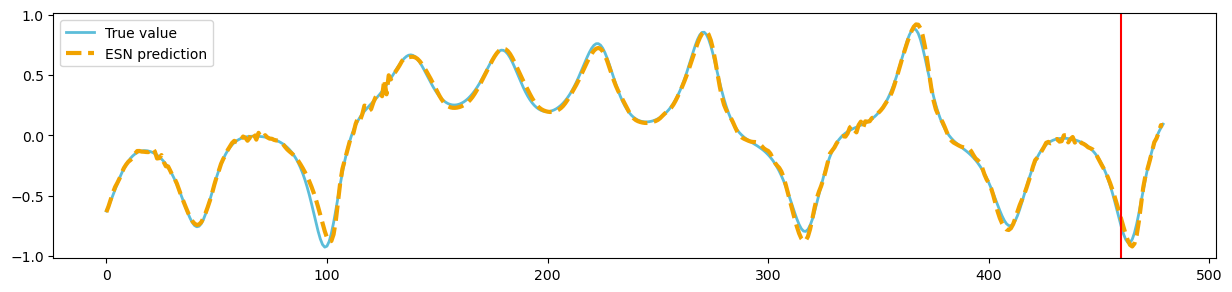

0.0284939125911448


C:\Users\nicks\AppData\Local\Temp\ipykernel_10316\1113348330.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res = math.sqrt(res/len(x_sim))


In [39]:
#Первый тестовый набор параметров 
units = 830
leak_rate = 0.55
spectral_radius = 0.6
input_scaling = 3.
connectivity = 0.51
input_connectivity = 0.51
regularization = 1.e-08
seed = 1534



#узел резервуара
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)
#выходной слой(считывающее устройство)
readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
#соединяем узлы и таким образом получаем модель 
esn = reservoir >> readout

#обучение модели
esn = esn.fit(X_train1, y_train1)
#делаем предсказание
y_pred1 = esn.run(X_test1, reset=False)
results(y_pred1, X[train+forecast:])
print(rmse(y_pred1[-100:], X[-100:]))
###HERE1

In [33]:
tmp = np.full(5000-len(y_pred1), None)
y_pred1_extended = np.concatenate([tmp.reshape(len(tmp), 1), y_pred1])

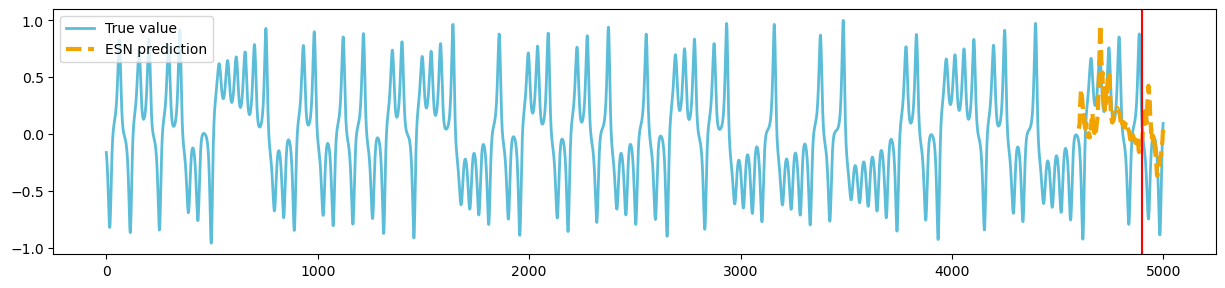

In [34]:
results(y_pred1_extended, X)